In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

movies = pd.read_csv('/content/gdrive/My Drive/Datasets/movie.csv')

Mounted at /content/gdrive


In [ ]:
# the function to extract titles
def extract_title(title):
   year = title[len(title)-5:len(title)-1]

   # some movies do not have the info about year in the column title. So, we should take care of the case as well.

   if year.isnumeric():
      title_no_year = title[:len(title)-7]
      return title_no_year
   else:
      return title
# the function to extract years
def extract_year(title):
   year = title[len(title)-5:len(title)-1]
   # some movies do not have the info about year in the column title. So, we should take care of the case as well.
   if year.isnumeric():
      return int(year)
   else:
      return np.nan
# change the column name from title to title_year
movies.rename(columns={'title':'title_year'}, inplace=True)
# remove leading and ending whitespaces in title_year
movies['title_year'] = movies['title_year'].apply(lambda x: x.strip())
# create the columns for title and year
movies['title'] = movies['title_year'].apply(extract_title)
movies['year'] = movies['title_year'].apply(extract_year)

In [ ]:
r,c = movies[movies['genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)
# remove the movies without genre information and reset the index
movies = movies[~(movies['genres']=='(no genres listed)')].reset_index(drop=True)

The number of movies which do not have info about genres: 246


<ipython-input-10-dc0b315a999d>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


Text(0, 0.5, 'Counts')

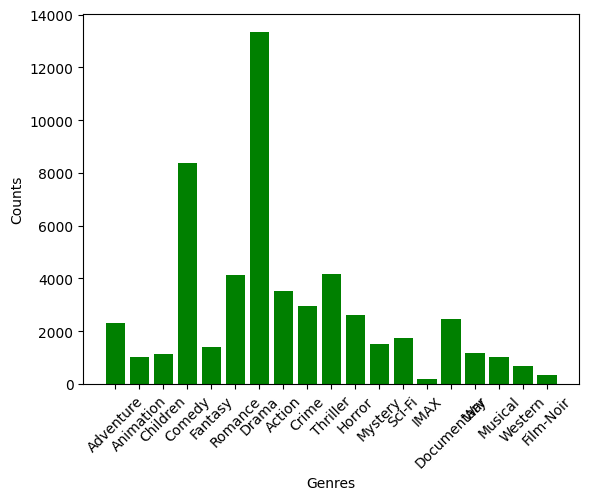

In [ ]:
# remove '|' in the genres column
movies['genres'] = movies['genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in movies.index:
   for g in movies.loc[i,'genres'].split(' '):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# change 'Sci-Fi' to 'SciFi' and 'Film-Noir' to 'Noir'
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','Noir')
# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(movies['genres'])

tfidf_matrix.shape


(27032, 19)

In [ ]:
print(list(enumerate(tfidf_vector.get_feature_names_out())))

[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'children'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'imax'), (11, 'musical'), (12, 'mystery'), (13, 'noir'), (14, 'romance'), (15, 'scifi'), (16, 'thriller'), (17, 'war'), (18, 'western')]


In [ ]:
from sklearn.metrics.pairwise import linear_kernel
# create the cosine similarity matrix
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix)
print(sim_matrix)

[[1.         0.81345076 0.15880421 ... 0.26371079 0.41905932 0.53751436]
 [0.81345076 1.         0.         ... 0.         0.51516249 0.66078291]
 [0.15880421 0.         1.         ... 0.60219081 0.         0.        ]
 ...
 [0.26371079 0.         0.60219081 ... 1.         0.         0.        ]
 [0.41905932 0.51516249 0.         ... 0.         1.         0.55506459]
 [0.53751436 0.66078291 0.         ... 0.         0.55506459 1.        ]]


In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
# create a function to find the closest title
def matching_score(a,b):
   return fuzz.ratio(a,b)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# a function to convert index to title_year
def get_title_year_from_index(index):
   return movies[movies.index == index]['title_year'].values[0]
# a function to convert index to title
def get_title_from_index(index):
   return movies[movies.index == index]['title'].values[0]
# a function to convert title to index
def get_index_from_title(title):
   return movies[movies.title == title].index.values[0]
# a function to return the most similar title to the words a user type
def find_closest_title(title):
   leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
   sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
   closest_title = get_title_from_index(sorted_leven_scores[0][0])
   distance_score = sorted_leven_scores[0][1]
   return closest_title, distance_score

In [ ]:
def contents_based_recommender(movie_user_likes, how_many):
   closest_title, distance_score = find_closest_title(movie_user_likes)
   # When a user does not make misspellings
   if distance_score == 100:
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      # remove the typed movie itself
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))

      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))
   # When a user makes misspellings
   else:
      print('Did you mean '+'\033[1m'+str(closest_title)+'\033[0m'+'?','\n')
      movie_index = get_index_from_title(closest_title)
      movie_list = list(enumerate(sim_matrix[int(movie_index)]))
      similar_movies = list(filter(lambda x:x[0] != int(movie_index), sorted(movie_list,key=lambda x:x[1], reverse=True)))
      print('Here\'s the list of movies similar to '+'\033[1m'+str(closest_title)+'\033[0m'+'.\n')
      for i,s in similar_movies[:how_many]:
         print(get_title_year_from_index(i))

In [ ]:
contents_based_recommender('Monsters, Inc.', 20)

Here's the list of movies similar to Monsters, Inc..

Toy Story (1995)
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
DuckTales: The Movie - Treasure of the Lost Lamp (1990)
Wild, The (2006)
Shrek the Third (2007)
Tale of Despereaux, The (2008)
Asterix and the Vikings (Astérix et les Vikings) (2006)
Turbo (2013)
Aladdin (1992)
Boxtrolls, The (2014)
Toy Story Toons: Hawaiian Vacation (2011)
Toy Story Toons: Small Fry (2011)
The Magic Crystal (2011)
Brother Bear 2 (2006)
Black Cauldron, The (1985)
Lord of the Rings, The (1978)
We're Back! A Dinosaur's Story (1993)


In [ ]:
contents_based_recommender('Casper\'s Haunted Christmas', 30)


Here's the list of movies similar to Casper's Haunted Christmas.

Gumby: The Movie (1995)
Swan Princess, The (1994)
Aristocats, The (1970)
Charlotte's Web (1973)
King and I, The (1999)
Doug's 1st Movie (1999)
Batman: Mask of the Phantasm (1993)
Tigger Movie, The (2000)
Road to El Dorado, The (2000)
Pokémon the Movie 2000 (2000)
Adventures of Ichabod and Mr. Toad, The (1949)
Monkey's Tale, A (Château des singes, Le) (1999)
Brave Little Toaster, The (1987)
Recess: School's Out (2001)
Pokémon 3: The Movie (2001)
Troll in Central Park, A (1994)
Care Bears Movie II: A New Generation (1986)
Jungle Book 2, The (2003)
Piglet's Big Movie (2003)
Pokémon Heroes (2003)
Teacher's Pet (2004)
Clifford's Really Big Movie (2004)
Pelle Svanslös (1981)
Pelle Svanslös i Amerikatt (1985)
Pooh's Heffalump Movie (2005)
Luxo Jr. (1986)
Doogal (2006)
Little Engine That Could, The (1991)
Dinosaurs: A Fun Filled Trip Back in Time (1987)
Playmobil: The Secret of Pirate Island (2009)
